## 창원시 안전도시 만들기

**창원시를 어떻게 해야 발전시킬 수 있을까?**
* '교통사고'라는 키워드에 입각해 "우리들이 어떻게해야 교통사고를 줄일 수 있을까?"라는 질문에 초점을 맞추도록 한다.
* 창원시 교통사고(사망자수) 데이터를 바탕으로 교통사고의 일련의 패턴을 찾는다.(언제, 어디서, 어떤 차량 혹은 어떤 도로등이 자주 발생시키는지)
* 위에서 찾은 문제들을 논문 혹은 여러자료들로부터 해결책을 찾는다.

### 목차
1. Raw Data Trimming
2. Data Summary
3. Feature Enginnering
4. Visualizing
    * 4-1. 어느 (월, 요일, 시간, 계절, 주야)에 사고가 많이 일어나는가?
    * 4-2. 어느 시간대( + (계절, 요일, 월))에 사고가 많이 일어나는가?
    * 4-3. 어떤 사고 유형일 때 사고가 많이 일어나는가?
        * 4-3-1. 사고분류(차대차, 차대사람)에서 어떤 사고가 피해를 많이 일으켰는가?
    * 4-4. 어떤 도로 유형일 때 사고가 많이 일어나는가?
    * 4-5. 어떤 차량 혹은 탈것이 사고를 많이 일으켰는가?
5. 격자노출
6. 사상자수가 많은 도로의 특징 파악

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import json
import folium
import matplotlib as mpl

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import platform
from matplotlib import font_manager, rc

path = 'c:/Windows/Fonts/malgun.ttf'
if platform.system() == 'Darwin' :
    rc('font', family = 'AppleeGothic')
elif platform.system() == 'Windows' :
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~')

### 1. Raw Data trimming

In [31]:
df = pd.read_csv('../data/사망자데이터.csv', encoding = 'cp949')
df.head(1)

,발생년,발생년월일시,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,...,사고유형,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2012,2012010101,야간,일,1,1,0,0,0,서울,...,차도통행중,안전운전 의무 불이행,단일로,기타단일로,승용차,보행자,949860,1957179,126.931891,37.61268


In [32]:
df.columns

Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '법규위반', '도로형태_대분류',
       '도로형태', '당사자종별_1당_대분류', '당사자종별_2당_대분류', '발생위치X_UTMK', '발생위치Y_UTMK',
       '경도', '위도'],
      dtype='object')

In [33]:
df[df['발생지시도'] == '경남']['발생지시군구']

3            합천군
6            의령군
21           의령군
23           고성군
49       창원시(통합)
          ...   
33860        진주시
33864        진주시
33911        양산시
33926        양산시
33947        양산시
Name: 발생지시군구, Length: 2982, dtype: object

In [34]:
df1 = df.loc[df['발생지시군구'] == '창원시(통합)', :]

In [35]:
df1.drop(columns = {'발생위치X_UTMK', '발생위치Y_UTMK',
                    '발생지시도', '발생지시군구'}, inplace = True)
df1.head(1)

,발생년,발생년월일시,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,사고유형_대분류,사고유형_중분류,사고유형,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류,경도,위도
49,2012,2012011520,야간,일,1,3,0,2,0,차대차,추돌,진행중 추돌,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,128.652091,35.273949


In [36]:
df1.reset_index(drop = True, inplace = True)
df1.head(3)

,발생년,발생년월일시,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,사고유형_대분류,사고유형_중분류,사고유형,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류,경도,위도
0,2012,2012011520,야간,일,1,3,0,2,0,차대차,추돌,진행중 추돌,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,128.652091,35.273949
1,2012,2012011804,야간,수,1,1,0,0,0,차대차,측면충돌,측면충돌,안전운전 의무 불이행,단일로,기타단일로,승용차,화물차,128.646870,35.274855
2,2012,2012010815,주간,일,1,3,2,0,0,차량단독,공작물충돌,공작물충돌,안전운전 의무 불이행,단일로,기타단일로,승용차,없음,128.547813,35.149728


### 2. Data Summary

In [37]:
df1.shape

(596, 19)

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 19 columns):
발생년             596 non-null int64
발생년월일시          596 non-null int64
주야              596 non-null object
요일              596 non-null object
사망자수            596 non-null int64
사상자수            596 non-null int64
중상자수            596 non-null int64
경상자수            596 non-null int64
부상신고자수          596 non-null int64
사고유형_대분류        596 non-null object
사고유형_중분류        596 non-null object
사고유형            596 non-null object
법규위반            596 non-null object
도로형태_대분류        596 non-null object
도로형태            596 non-null object
당사자종별_1당_대분류    596 non-null object
당사자종별_2당_대분류    596 non-null object
경도              596 non-null float64
위도              596 non-null float64
dtypes: float64(2), int64(7), object(10)
memory usage: 88.6+ KB


In [39]:
df1.describe(include = ['O'])

,주야,요일,사고유형_대분류,사고유형_중분류,사고유형,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
count,596,596,596,596,596,596,596,596,596,596
unique,2,7,3,14,17,8,4,12,10,11
top,야간,월,차대사람,기타,기타,안전운전 의무 불이행,단일로,기타단일로,승용차,보행자
freq,339,100,262,135,135,445,364,320,314,262


### 3. Feature Enginnering

In [41]:
df1['년월일'] = df1['발생년월일시'].apply(lambda x: str(x)[:-2])
df1['시간'] = df1['발생년월일시'].apply(lambda x: str(x)[-2:])
df1['월'] = df1['년월일'].apply(lambda x: calendar.month_name[datetime.strptime(str(x), '%Y%m%d').month])

In [42]:
df1[['년월일', '시간', '요일', '월']].head(3)

,년월일,시간,요일,월
0,20120115,20,일,January
1,20120118,04,수,January
2,20120108,15,일,January


In [14]:
Categoryvarlist = ['주야', '요일', '사고유형_대분류', '사고유형_중분류', '사고유형', '법규위반', '도로형태_대분류', '도로형태',
                   '당사자종별_1당_대분류', '당사자종별_2당_대분류']

for var in Categoryvarlist :
    df1[var] = df1[var].astype('category')

In [43]:
df1.drop(['발생년', '발생년월일시'], axis = 1, inplace = True)
df1.rename(columns = {'사고유형_대분류' : '사고_대',
                      '사고유형_중분류' : '사고_중',
                      '도로형태_대분류' : '도로',
                      '당사자종별_1당_대분류' : '1당',
                      '당사자종별_2당_대분류' : '2당',}, inplace = True)

In [44]:
df1.head(3)

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,사고_대,사고_중,사고유형,법규위반,도로,도로형태,1당,2당,경도,위도,년월일,시간,월
0,야간,일,1,3,0,2,0,차대차,추돌,진행중 추돌,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,128.652091,35.273949,20120115,20,January
1,야간,수,1,1,0,0,0,차대차,측면충돌,측면충돌,안전운전 의무 불이행,단일로,기타단일로,승용차,화물차,128.646870,35.274855,20120118,04,January
2,주간,일,1,3,2,0,0,차량단독,공작물충돌,공작물충돌,안전운전 의무 불이행,단일로,기타단일로,승용차,없음,128.547813,35.149728,20120108,15,January


In [45]:
df1 = df1[['년월일', '월', '요일', '시간', '주야', '사고_대', '사고_중', '사고유형', '도로', '도로형태', '법규위반',
           '1당', '2당', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수', '경도', '위도']]
df1.head(3)

,년월일,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,사상자수,중상자수,경상자수,부상신고자수,경도,위도
0,20120115,January,일,20,야간,차대차,추돌,진행중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,0,2,0,128.652091,35.273949
1,20120118,January,수,04,야간,차대차,측면충돌,측면충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,화물차,1,1,0,0,0,128.646870,35.274855
2,20120108,January,일,15,주간,차량단독,공작물충돌,공작물충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,없음,1,3,2,0,0,128.547813,35.149728


In [46]:
df1['피해인원'] = df1['사상자수']
df1 = df1[['년월일', '월', '요일', '시간', '주야', '사고_대', '사고_중', '사고유형', '도로', '도로형태', '법규위반',
           '1당', '2당', '사망자수', '피해인원', '경도', '위도']]
df1.head(3)

,년월일,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,피해인원,경도,위도
0,20120115,January,일,20,야간,차대차,추돌,진행중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,128.652091,35.273949
1,20120118,January,수,04,야간,차대차,측면충돌,측면충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,화물차,1,1,128.646870,35.274855
2,20120108,January,일,15,주간,차량단독,공작물충돌,공작물충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,없음,1,3,128.547813,35.149728


In [47]:
df1['계절'] = None

for i in range(len(df1)) :
    if df1['월'][i] == 'December' or df1['월'][i] == 'January' or df1['월'][i] == 'February' :
        df1['계절'][i] = 'Winter'
    elif df1['월'][i] == 'March' or df1['월'][i] == 'April' or df1['월'][i] == 'May' :
        df1['계절'][i] = 'Spring' 
    elif df1['월'][i] == 'June' or df1['월'][i] == 'July' or df1['월'][i] == 'August' :
        df1['계절'][i] = 'Summer'
    else :
        df1['계절'][i] = 'Fall'

In [48]:
df1.columns

Index(['년월일', '월', '요일', '시간', '주야', '사고_대', '사고_중', '사고유형', '도로', '도로형태',
       '법규위반', '1당', '2당', '사망자수', '피해인원', '경도', '위도', '계절'],
      dtype='object')

In [49]:
df1 = df1[['년월일', '계절', '월', '요일', '시간', '주야', '사고_대', '사고_중', '사고유형', '도로', '도로형태', '법규위반',
           '1당', '2당', '사망자수', '피해인원', '경도', '위도']]
df1.head(1)

,년월일,계절,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,피해인원,경도,위도
0,20120115,Winter,January,일,20,야간,차대차,추돌,진행중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,128.652091,35.273949


In [50]:
df1.shape

(596, 18)

In [51]:
df1.head(10)

,년월일,계절,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,피해인원,경도,위도
0,20120115,Winter,January,일,20,야간,차대차,추돌,진행중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,128.652091,35.273949
1,20120118,Winter,January,수,04,야간,차대차,측면충돌,측면충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,화물차,1,1,128.646870,35.274855
2,20120108,Winter,January,일,15,주간,차량단독,공작물충돌,공작물충돌,단일로,기타단일로,안전운전 의무 불이행,승용차,없음,1,3,128.547813,35.149728
3,20120113,Winter,January,금,07,주간,차대차,기타,기타,교차로,교차로부근,신호위반,승합차,자전거,1,1,128.683957,35.225323
4,20120117,Winter,January,화,10,주간,차대차,기타,기타,교차로,교차로내,기타,원동기장치자전거,승용차,1,1,128.656835,35.149620
5,20120119,Winter,January,목,17,주간,차대사람,횡단중,횡단중,단일로,교량위,안전운전 의무 불이행,이륜차,보행자,1,1,128.575705,35.229452
6,20120117,Winter,January,화,15,주간,차량단독,공작물충돌,공작물충돌,교차로,교차로내,안전운전 의무 불이행,승용차,없음,3,4,128.416343,35.100209
7,20120131,Winter,January,화,02,야간,차대사람,길가장자리구역통행중,길가장자리구역통행중,단일로,기타단일로,안전운전 의무 불이행,승합차,보행자,1,1,128.482007,35.113852
8,20120128,Winter,January,토,11,주간,차대차,기타,기타,단일로,기타단일로,신호위반,원동기장치자전거,승용차,1,1,128.684628,35.277223
9,20120206,Winter,February,월,12,주간,차대사람,횡단중,횡단중,기타/불명,기타/불명,안전운전 의무 불이행,특수차,보행자,1,1,128.511086,35.145748


In [53]:
df1.describe(include = ['O'])

,년월일,계절,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당
count,596,596,596,596,596,596,596,596,596,596,596,596,596,596
unique,543,4,12,7,24,2,3,14,17,4,12,8,10,11
top,20121216,Summer,August,월,05,야간,차대사람,기타,기타,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자
freq,3,169,65,100,36,339,262,135,135,364,320,445,314,262


### 4. Visualizing

#### 4-1. 어느 (월, 요일, 시간, 계절, 주야)에 사고가 많이 일어나는가?

[Text(0, 0.5, '피해인원 합계'), Text(0.5, 0, '계절'), Text(0.5, 1.0, '계절별 피해인원 합계')]

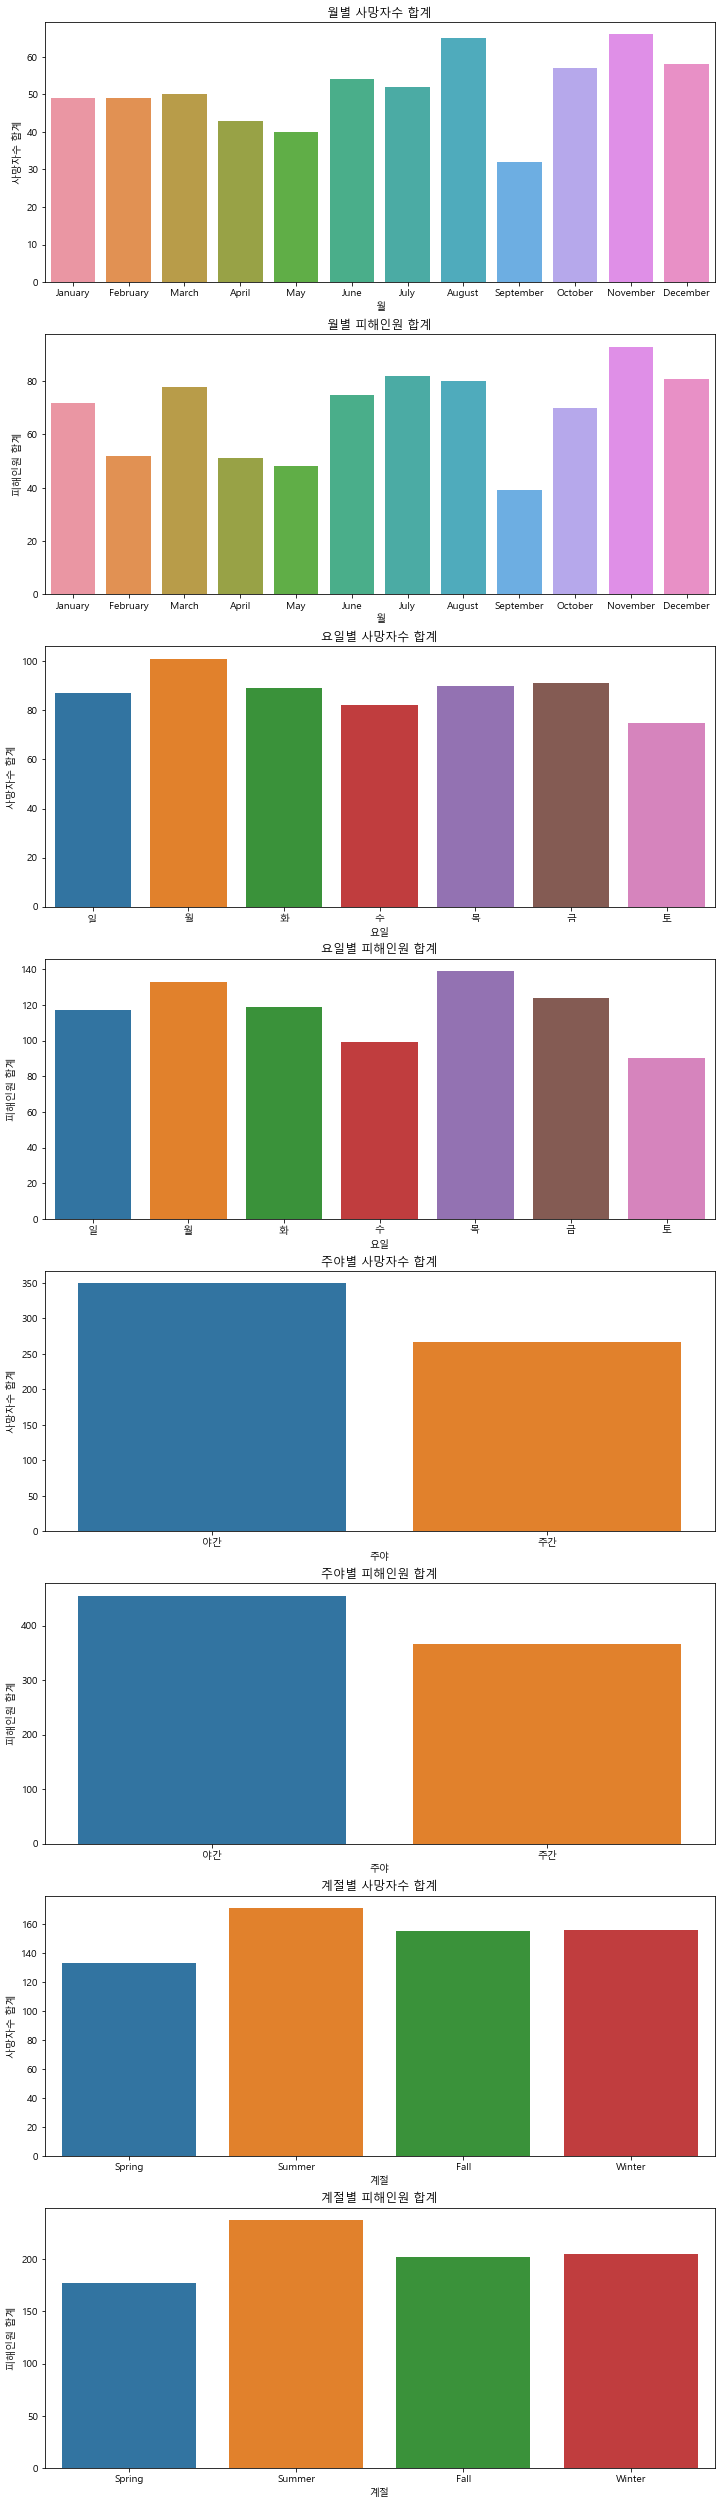

In [22]:
fig, (ax1, ax2, ax3,
      ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows = 8)
fig.set_size_inches(12, 45)
MonthOrder = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
             'August', 'September', 'October', 'November', 'December']
DayOrder = ['일', '월', '화', '수', '목', '금', '토']
DNOrder = ['야간', '주간']
SeasonOrder = ['Spring', 'Summer', 'Fall', 'Winter']

monthAggregated = pd.DataFrame(df1.groupby('월')['사망자수'].sum()).reset_index()
monthSorted = monthAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = monthSorted, x = '월', y = '사망자수', ax = ax1, order = MonthOrder)
ax1.set(xlabel = '월', ylabel = '사망자수 합계', title = '월별 사망자수 합계')

monthAggregated = pd.DataFrame(df1.groupby('월')['피해인원'].sum()).reset_index()
monthSorted = monthAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = monthSorted, x = '월', y = '피해인원', ax = ax2, order = MonthOrder)
ax2.set(xlabel = '월', ylabel = '피해인원 합계', title = '월별 피해인원 합계')

dayAggregated = pd.DataFrame(df1.groupby('요일')['사망자수'].sum()).reset_index()
daySorted = dayAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = daySorted, x = '요일', y = '사망자수', ax = ax3, order = DayOrder)
ax3.set(xlabel = '요일', ylabel = '사망자수 합계', title = '요일별 사망자수 합계')

dayAggregated = pd.DataFrame(df1.groupby('요일')['피해인원'].sum()).reset_index()
daySorted = dayAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = daySorted, x = '요일', y = '피해인원', ax = ax4, order = DayOrder)
ax4.set(xlabel = '요일', ylabel = '피해인원 합계', title = '요일별 피해인원 합계')

dnAggregated = pd.DataFrame(df1.groupby('주야')['사망자수'].sum()).reset_index()
dnSorted = dnAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = dnSorted, x = '주야', y = '사망자수', ax = ax5, order = DNOrder)
ax5.set(xlabel = '주야', ylabel = '사망자수 합계', title = '주야별 사망자수 합계')

dnAggregated = pd.DataFrame(df1.groupby('주야')['피해인원'].sum()).reset_index()
dnSorted = dnAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = dnSorted, x = '주야', y = '피해인원', ax = ax6, order = DNOrder)
ax6.set(xlabel = '주야', ylabel = '피해인원 합계', title = '주야별 피해인원 합계')

seasonAggregated = pd.DataFrame(df1.groupby('계절')['사망자수'].sum()).reset_index()
seasonSorted = seasonAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = seasonSorted, x = '계절', y = '사망자수', ax = ax7, order = SeasonOrder)
ax7.set(xlabel = '계절', ylabel = '사망자수 합계', title = '계절별 사망자수 합계')

seasonAggregated = pd.DataFrame(df1.groupby('계절')['피해인원'].sum()).reset_index()
seasonSorted = seasonAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = seasonSorted, x = '계절', y = '피해인원', ax = ax8, order = SeasonOrder)
ax8.set(xlabel = '계절', ylabel = '피해인원 합계', title = '계절별 피해인원 합계')

#### 4-2. 어느 시간대( + (계절, 요일, 월))에 사고가 많이 일어나는가?

[Text(0, 0.5, '피해인원'),
 Text(0.5, 0, '시간'),
 Text(0.5, 1.0, '월별 시간대에 따른 피해인원 합계'),
 None]

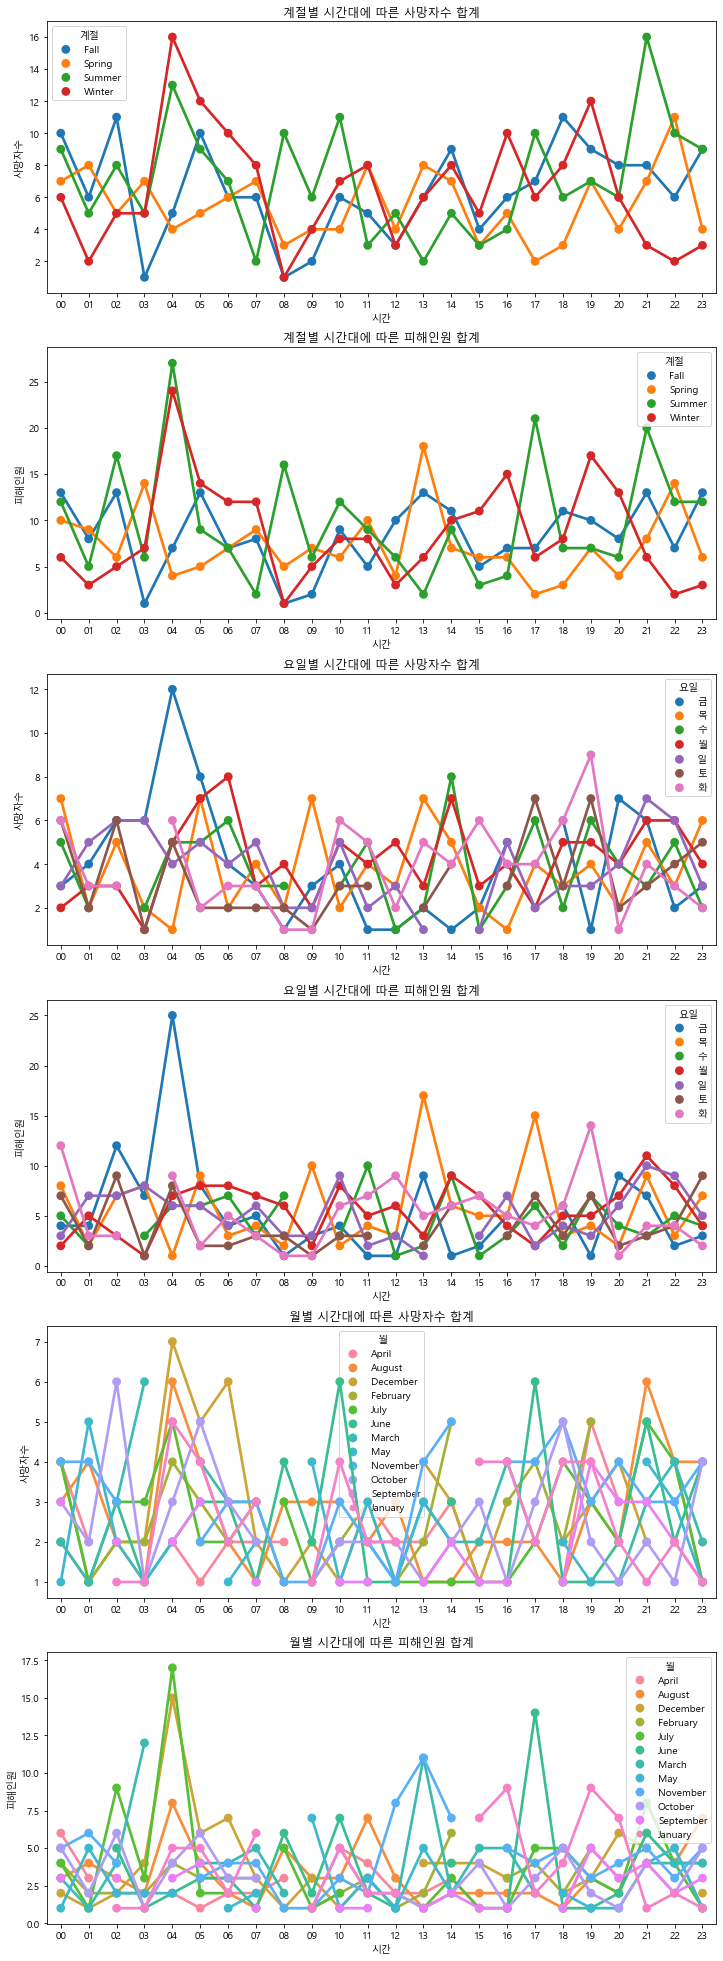

In [23]:
fig, (ax1, ax2, ax3,
     ax4, ax5, ax6) = plt.subplots(nrows = 6)
fig.set_size_inches(12, 35)

hourAggregated_season = pd.DataFrame(df1.groupby(['시간', '계절']
                                          , sort = True)['사망자수'].sum()).reset_index()
sns.pointplot(x = hourAggregated_season['시간'],
              y = hourAggregated_season['사망자수'],
              hue = hourAggregated_season['계절'],
              data = hourAggregated_season, join = True, ax = ax1)
ax1.set(xlabel = '시간', ylabel = '사망자수', 
       title = '계절별 시간대에 따른 사망자수 합계', label = 'big')

hourAggregated_season = pd.DataFrame(df1.groupby(['시간', '계절']
                                          , sort = True)['피해인원'].sum()).reset_index()
sns.pointplot(x = hourAggregated_season['시간'],
              y = hourAggregated_season['피해인원'],
              hue = hourAggregated_season['계절'],
              data = hourAggregated_season, join = True, ax = ax2)
ax2.set(xlabel = '시간', ylabel = '피해인원', 
       title = '계절별 시간대에 따른 피해인원 합계', label = 'big')


hourAggregated_weekday = pd.DataFrame(df1.groupby(['시간', '요일']
                                          , sort = True)['사망자수'].sum()).reset_index()
sns.pointplot(x = hourAggregated_weekday['시간'],
              y = hourAggregated_weekday['사망자수'],
              hue = hourAggregated_weekday['요일'],
              data = hourAggregated_weekday, join = True, ax = ax3)
ax3.set(xlabel = '시간', ylabel = '사망자수', 
       title = '요일별 시간대에 따른 사망자수 합계', label = 'big')

hourAggregated_weekday = pd.DataFrame(df1.groupby(['시간', '요일']
                                          , sort = True)['피해인원'].sum()).reset_index()
sns.pointplot(x = hourAggregated_weekday['시간'],
              y = hourAggregated_weekday['피해인원'],
              hue = hourAggregated_weekday['요일'],
              data = hourAggregated_weekday, join = True, ax = ax4)
ax4.set(xlabel = '시간', ylabel = '피해인원', 
       title = '요일별 시간대에 따른 피해인원 합계', label = 'big')


hourAggregated_month = pd.DataFrame(df1.groupby(['시간', '월']
                                          , sort = True)['사망자수'].sum()).reset_index()
sns.pointplot(x = hourAggregated_month['시간'],
              y = hourAggregated_month['사망자수'],
              hue = hourAggregated_month['월'],
              data = hourAggregated_month, join = True, ax = ax5)
ax5.set(xlabel = '시간', ylabel = '사망자수', 
       title = '월별 시간대에 따른 사망자수 합계', label = 'big')

hourAggregated_month = pd.DataFrame(df1.groupby(['시간', '월']
                                          , sort = True)['피해인원'].sum()).reset_index()
sns.pointplot(x = hourAggregated_month['시간'],
              y = hourAggregated_month['피해인원'],
              hue = hourAggregated_month['월'],
              data = hourAggregated_month, join = True, ax = ax6)
ax6.set(xlabel = '시간', ylabel = '피해인원', 
       title = '월별 시간대에 따른 피해인원 합계', label = 'big')

#### 4-3. 어떤 사고 유형일 때 사고가 많이 일어나는가?

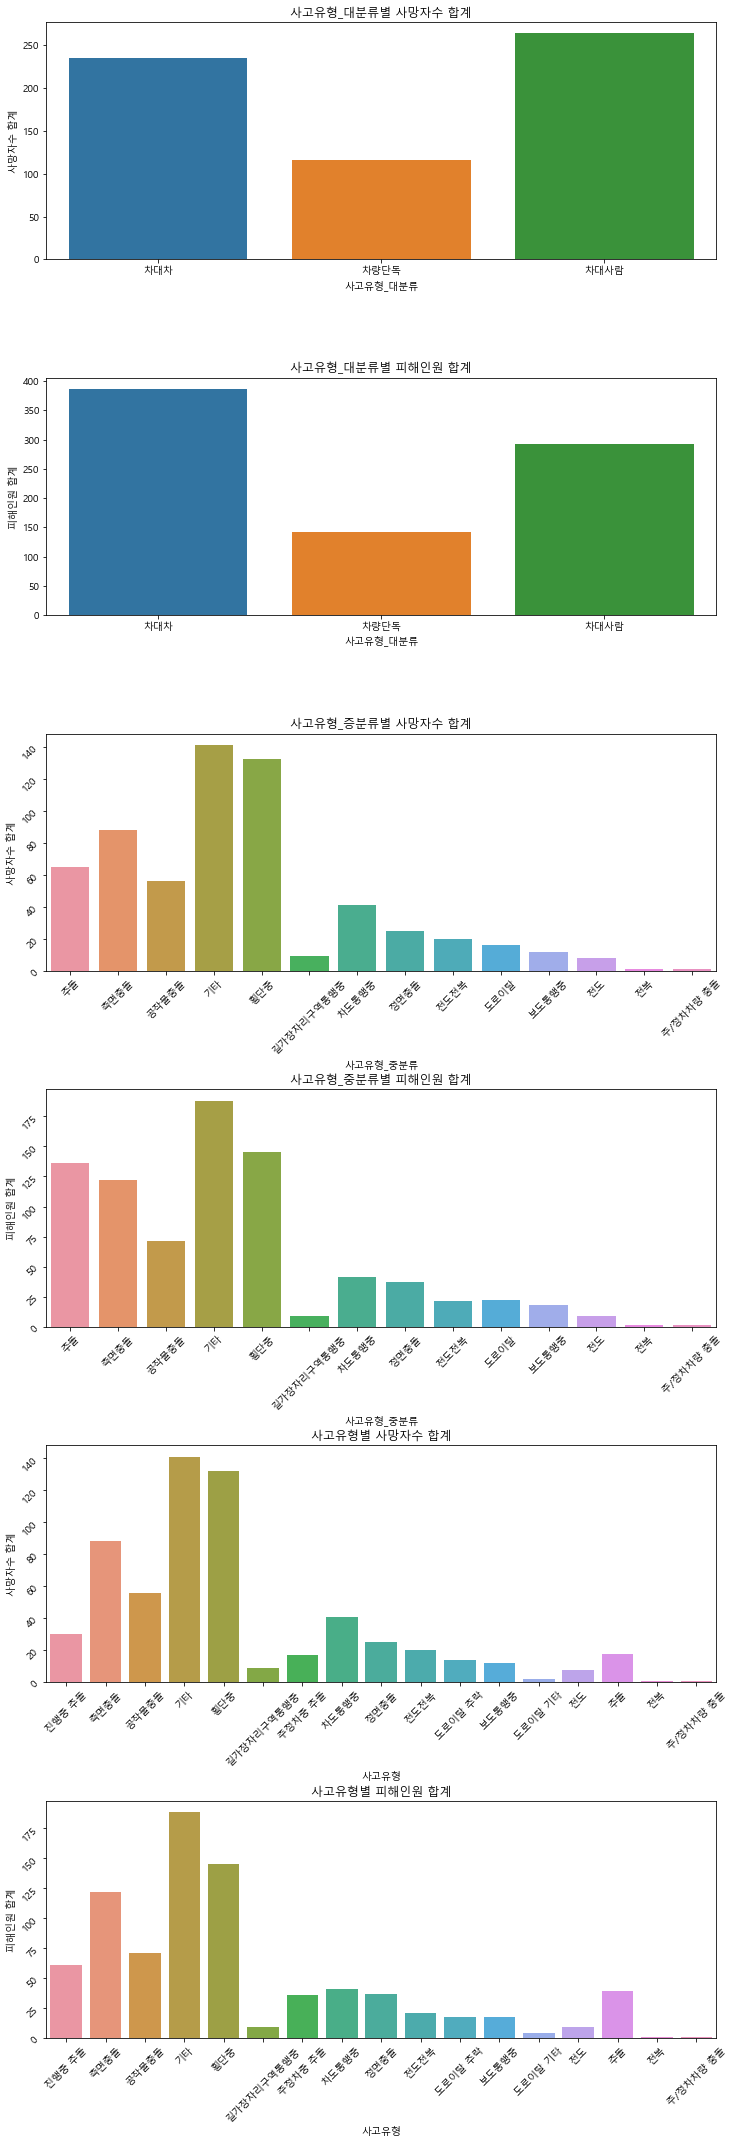

In [24]:
fig, (ax1, ax2, ax3,
     ax4, ax5,ax6) = plt.subplots(nrows = 6)
fig.set_size_inches(12, 35)
bigOrder = [df1['사고_대'].unique()[0], df1['사고_대'].unique()[1], df1['사고_대'].unique()[2]]
smallOrder = [df1['사고_중'].unique()[0], df1['사고_중'].unique()[1],
             df1['사고_중'].unique()[2], df1['사고_중'].unique()[3],
              df1['사고_중'].unique()[4], df1['사고_중'].unique()[5],
              df1['사고_중'].unique()[6], df1['사고_중'].unique()[7],
              df1['사고_중'].unique()[8], df1['사고_중'].unique()[9],
              df1['사고_중'].unique()[10], df1['사고_중'].unique()[11],
             df1['사고_중'].unique()[12], df1['사고_중'].unique()[13]]
accidentOrder = [df1['사고유형'].unique()[0], df1['사고유형'].unique()[1],
             df1['사고유형'].unique()[2], df1['사고유형'].unique()[3],
              df1['사고유형'].unique()[4], df1['사고유형'].unique()[5],
              df1['사고유형'].unique()[6], df1['사고유형'].unique()[7],
              df1['사고유형'].unique()[8], df1['사고유형'].unique()[9],
              df1['사고유형'].unique()[10], df1['사고유형'].unique()[11],
             df1['사고유형'].unique()[12], df1['사고유형'].unique()[13],
                 df1['사고유형'].unique()[14], df1['사고유형'].unique()[15],
                  df1['사고유형'].unique()[16]]

accbigAggregated = pd.DataFrame(df1.groupby('사고_대')['사망자수'].sum())\
                        .reset_index()
accbigSorted = accbigAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = accbigSorted, x = '사고_대', y = '사망자수',
            ax = ax1, order = bigOrder)
ax1.set(xlabel = '사고유형_대분류', ylabel = '사망자수 합계',
        title = '사고유형_대분류별 사망자수 합계')

accbigAggregated = pd.DataFrame(df1.groupby('사고_대')['피해인원'].sum()).\
                        reset_index()
accbigSorted = accbigAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = accbigSorted, x = '사고_대', y = '피해인원',
            ax = ax2, order = bigOrder)
ax2.set(xlabel = '사고유형_대분류', ylabel = '피해인원 합계',
        title = '사고유형_대분류별 피해인원 합계')

accsmallAggregated = pd.DataFrame(df1.groupby('사고_중')['사망자수'].sum())\
                        .reset_index()
accsmallSorted = accsmallAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = accsmallSorted, x = '사고_중', y = '사망자수',
            ax = ax3, order = smallOrder)
ax3.set(xlabel = '사고유형_중분류', ylabel = '사망자수 합계',
        title = '사고유형_증분류별 사망자수 합계')
ax3.tick_params(labelrotation=45)

accsmallAggregated = pd.DataFrame(df1.groupby('사고_중')['피해인원'].sum()).\
                        reset_index()
accsmallSorted = accsmallAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = accsmallSorted, x = '사고_중', y = '피해인원',
            ax = ax4, order = smallOrder)
ax4.set(xlabel = '사고유형_중분류', ylabel = '피해인원 합계',
        title = '사고유형_중분류별 피해인원 합계')
ax4.tick_params(labelrotation=45)


accAggregated = pd.DataFrame(df1.groupby('사고유형')['사망자수'].sum())\
                        .reset_index()
accSorted = accAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = accSorted, x = '사고유형', y = '사망자수',
            ax = ax5, order = accidentOrder)
ax5.set(xlabel = '사고유형', ylabel = '사망자수 합계',
        title = '사고유형별 사망자수 합계')
ax5.tick_params(labelrotation=45) 

accAggregated = pd.DataFrame(df1.groupby('사고유형')['피해인원'].sum()).\
                        reset_index()
accSorted = accAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = accSorted, x = '사고유형', y = '피해인원',
            ax = ax6, order = accidentOrder)
ax6.set(xlabel = '사고유형', ylabel = '피해인원 합계',
        title = '사고유형별 피해인원 합계')
ax6.tick_params(labelrotation=45)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

#### 4-3-1. 사고분류(차대차, 차대사람)에서 어떤 사고가 피해를 많이 일으켰는가?

In [25]:
df1[df1['사고_대'] == '차대차']['사고_중'].unique()

[추돌, 측면충돌, 기타, 정면충돌]
Categories (4, object): [추돌, 측면충돌, 기타, 정면충돌]

In [26]:
df1[df1['사고_대'] == '차대사람']['사고_중'].unique()

[횡단중, 길가장자리구역통행중, 기타, 차도통행중, 보도통행중]
Categories (5, object): [횡단중, 길가장자리구역통행중, 기타, 차도통행중, 보도통행중]

In [27]:
df1[df1['사고_대'] == '차량단독']['사고_중'].unique()

[공작물충돌, 기타, 전도전복, 도로이탈, 전도, 전복, 주/정차차량 충돌]
Categories (7, object): [공작물충돌, 기타, 전도전복, 도로이탈, 전도, 전복, 주/정차차량 충돌]

In [28]:
tmp1 = df1[df1['사고_대'] == '차대차']

In [29]:
tmp2 = df1[df1['사고_대'] == '차대사람']

In [30]:
tmp3 = df1[df1['사고_대'] == '차량단독']

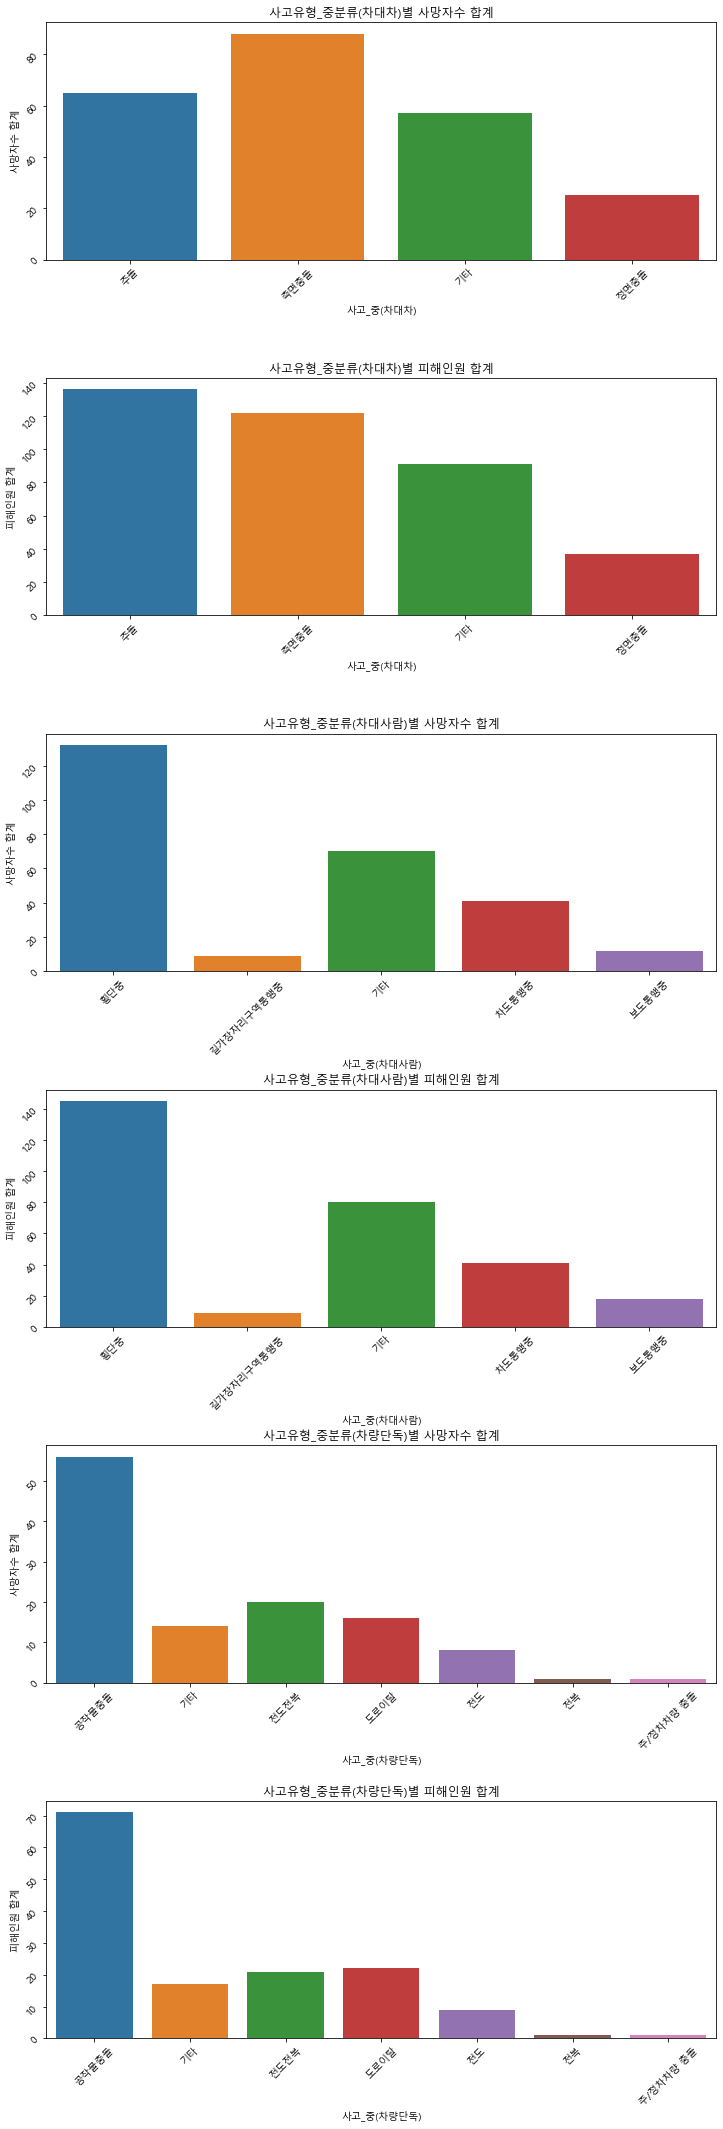

In [31]:
fig, (ax1, ax2, ax3,
      ax4, ax5, ax6) = plt.subplots(nrows = 6)
fig.set_size_inches(12, 35)
sub1Order = [tmp1['사고_중'].unique()[0], tmp1['사고_중'].unique()[1],
             tmp1['사고_중'].unique()[2], tmp1['사고_중'].unique()[3]]
sub2Order = [tmp2['사고_중'].unique()[0], tmp2['사고_중'].unique()[1],
             tmp2['사고_중'].unique()[2], tmp2['사고_중'].unique()[3],
             tmp2['사고_중'].unique()[4]]
sub3Order = [tmp3['사고_중'].unique()[0], tmp3['사고_중'].unique()[1],
             tmp3['사고_중'].unique()[2], tmp3['사고_중'].unique()[3],
             tmp3['사고_중'].unique()[4], tmp3['사고_중'].unique()[5],
             tmp3['사고_중'].unique()[6]]

tmp1Aggregate = pd.DataFrame(tmp1.groupby('사고_중')['사망자수'].sum())\
                        .reset_index()
tmp1Sorted = tmp1Aggregate.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = tmp1Sorted, x = '사고_중', y = '사망자수',
            ax = ax1, order = sub1Order)
ax1.set(xlabel = '사고_중(차대차)', ylabel = '사망자수 합계',
        title = '사고유형_중분류(차대차)별 사망자수 합계')
ax1.tick_params(labelrotation=45)

tmp1Aggregate = pd.DataFrame(tmp1.groupby('사고_중')['피해인원'].sum())\
                        .reset_index()
tmp1Sorted = tmp1Aggregate.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = tmp1Sorted, x = '사고_중', y = '피해인원',
            ax = ax2, order = sub1Order)
ax2.set(xlabel = '사고_중(차대차)', ylabel = '피해인원 합계',
        title = '사고유형_중분류(차대차)별 피해인원 합계')
ax2.tick_params(labelrotation=45)


tmp2Aggregate = pd.DataFrame(tmp2.groupby('사고_중')['사망자수'].sum())\
                        .reset_index()
tmp2Sorted = tmp2Aggregate.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = tmp2Sorted, x = '사고_중', y = '사망자수',
            ax = ax3, order = sub2Order)
ax3.set(xlabel = '사고_중(차대사람)', ylabel = '사망자수 합계',
        title = '사고유형_중분류(차대사람)별 사망자수 합계')
ax3.tick_params(labelrotation=45)

tmp2Aggregate = pd.DataFrame(tmp2.groupby('사고_중')['피해인원'].sum())\
                        .reset_index()
tmp2Sorted = tmp2Aggregate.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = tmp2Sorted, x = '사고_중', y = '피해인원',
            ax = ax4, order = sub2Order)
ax4.set(xlabel = '사고_중(차대사람)', ylabel = '피해인원 합계',
        title = '사고유형_중분류(차대사람)별 피해인원 합계')
ax4.tick_params(labelrotation=45)


tmp3Aggregate = pd.DataFrame(tmp3.groupby('사고_중')['사망자수'].sum())\
                        .reset_index()
tmp3Sorted = tmp3Aggregate.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = tmp3Sorted, x = '사고_중', y = '사망자수',
            ax = ax5, order = sub3Order)
ax5.set(xlabel = '사고_중(차량단독)', ylabel = '사망자수 합계',
        title = '사고유형_중분류(차량단독)별 사망자수 합계')
ax5.tick_params(labelrotation=45)

tmp3Aggregate = pd.DataFrame(tmp3.groupby('사고_중')['피해인원'].sum())\
                        .reset_index()
tmp3Sorted = tmp3Aggregate.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = tmp3Sorted, x = '사고_중', y = '피해인원',
            ax = ax6, order = sub3Order)
ax6.set(xlabel = '사고_중(차량단독)', ylabel = '피해인원 합계',
        title = '사고유형_중분류(차량단독)별 피해인원 합계')
ax6.tick_params(labelrotation=45)


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

#### 4-4. 어떤 도로 유형일 때 사고가 많이 일어나는가?

In [32]:
df1['도로'].unique()

[단일로, 교차로, 기타/불명, 기타]
Categories (4, object): [단일로, 교차로, 기타/불명, 기타]

In [33]:
df1['도로형태'].unique()

[기타단일로, 교차로부근, 교차로내, 교량위, 기타/불명, ..., 터널안, 고가도로위, 교차로횡단보도내, 기타, 지하차도(도로)내]
Length: 12
Categories (12, object): [기타단일로, 교차로부근, 교차로내, 교량위, ..., 고가도로위, 교차로횡단보도내, 기타, 지하차도(도로)내]

[Text(0, 0.5, '피해인원 합계'),
 Text(0.5, 0, '도로형태'),
 Text(0.5, 1.0, '도로형태별 피해인원 합계')]

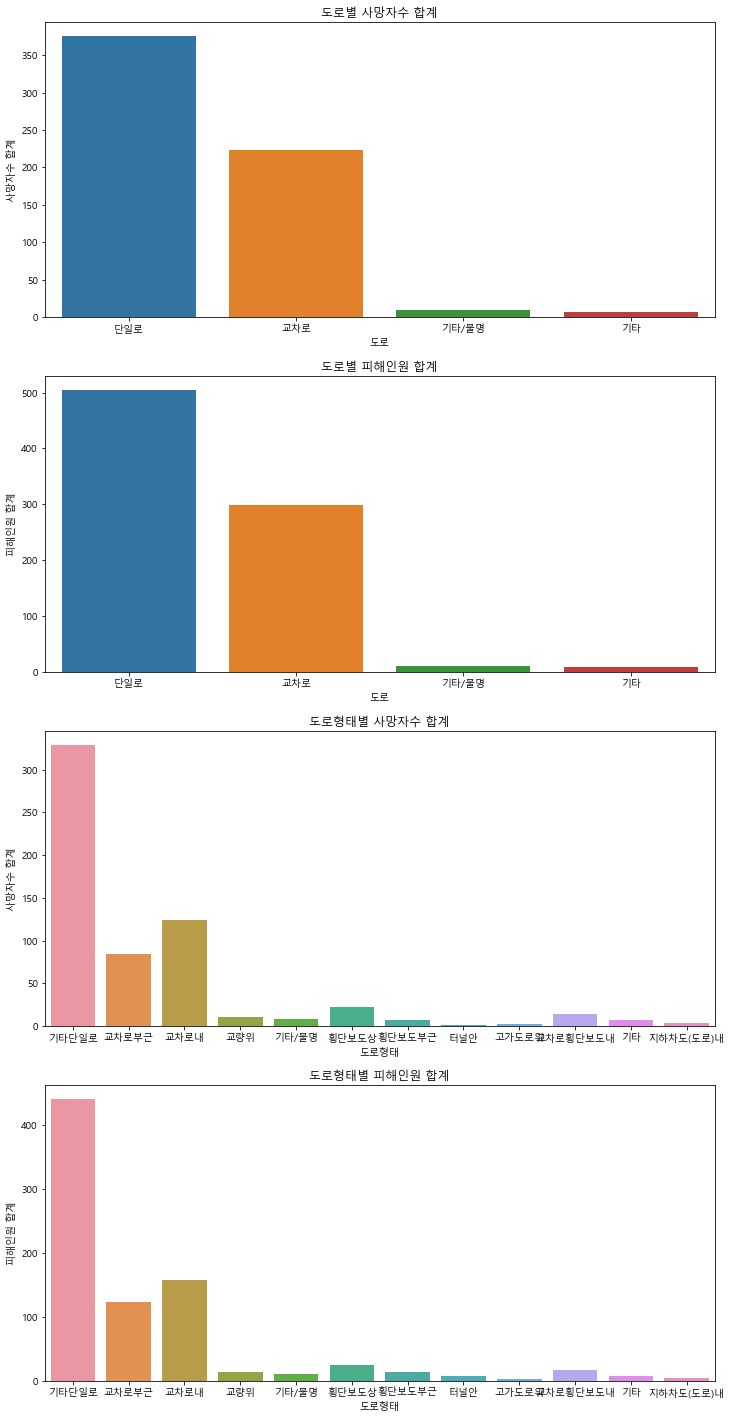

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(12, 25)
load1Order = [df1['도로'].unique()[0], df1['도로'].unique()[1],
             df1['도로'].unique()[2], df1['도로'].unique()[3]]
load2Order = [df1['도로형태'].unique()[0], df1['도로형태'].unique()[1],
             df1['도로형태'].unique()[2], df1['도로형태'].unique()[3],
              df1['도로형태'].unique()[4], df1['도로형태'].unique()[5],
              df1['도로형태'].unique()[6], df1['도로형태'].unique()[7],
              df1['도로형태'].unique()[8], df1['도로형태'].unique()[9],
              df1['도로형태'].unique()[10], df1['도로형태'].unique()[11]]

load1Aggregated = pd.DataFrame(df1.groupby('도로')['사망자수'].sum())\
                        .reset_index()
load1Sorted = load1Aggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = load1Sorted, x = '도로', y = '사망자수',
            ax = ax1, order = load1Order)
ax1.set(xlabel = '도로', ylabel = '사망자수 합계',
        title = '도로별 사망자수 합계')

load1Aggregated = pd.DataFrame(df1.groupby('도로')['피해인원'].sum())\
                        .reset_index()
load1Sorted = load1Aggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = load1Sorted, x = '도로', y = '피해인원',
            ax = ax2, order = load1Order)
ax2.set(xlabel = '도로', ylabel = '피해인원 합계',
        title = '도로별 피해인원 합계')


load2Aggregated = pd.DataFrame(df1.groupby('도로형태')['사망자수'].sum())\
                        .reset_index()
load2Sorted = load2Aggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = load2Sorted, x = '도로형태', y = '사망자수',
            ax = ax3, order = load2Order)
ax3.set(xlabel = '도로형태', ylabel = '사망자수 합계',
        title = '도로형태별 사망자수 합계')

load2Aggregated = pd.DataFrame(df1.groupby('도로형태')['피해인원'].sum())\
                        .reset_index()
load2Sorted = load2Aggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = load2Sorted, x = '도로형태', y = '피해인원',
            ax = ax4, order = load2Order)
ax4.set(xlabel = '도로형태', ylabel = '피해인원 합계',
        title = '도로형태별 피해인원 합계')

#### 4-4. 어떤 법규를 위반했을 때 사고가 많이 일어나는가?

In [35]:
df1['법규위반'].unique()

[안전운전 의무 불이행, 신호위반, 기타, 과속, 보행자 보호의무 위반, 안전거리 미확보, 교차로 통행방법 위반, 중앙선 침범]
Categories (8, object): [안전운전 의무 불이행, 신호위반, 기타, 과속, 보행자 보호의무 위반, 안전거리 미확보, 교차로 통행방법 위반, 중앙선 침범]

[Text(0, 0.5, '피해인원 합계'),
 Text(0.5, 0, '법규위반'),
 Text(0.5, 1.0, '법규위반별 피해인원 합계')]

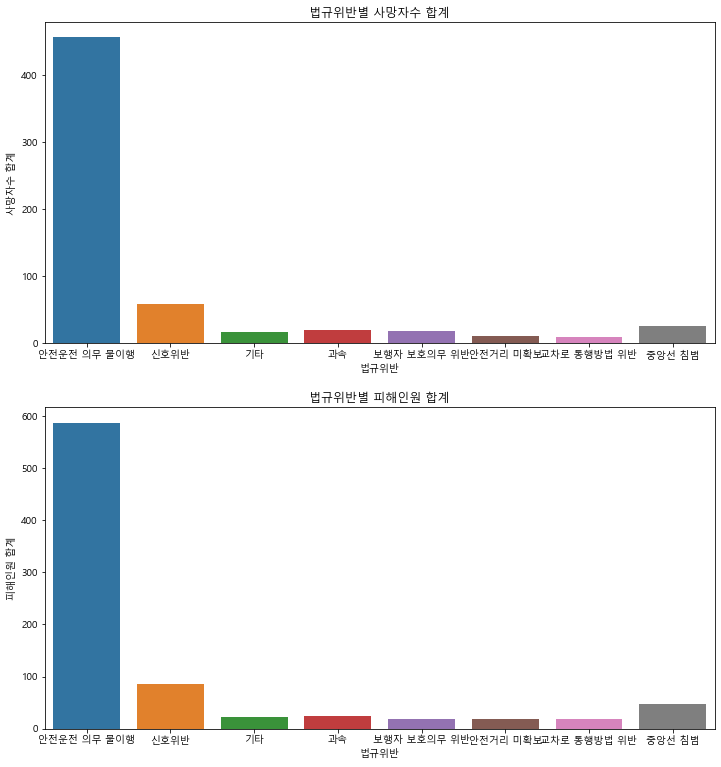

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(12, 13)
rawOrder = [df1['법규위반'].unique()[0], df1['법규위반'].unique()[1],
             df1['법규위반'].unique()[2], df1['법규위반'].unique()[3],
              df1['법규위반'].unique()[4], df1['법규위반'].unique()[5],
              df1['법규위반'].unique()[6], df1['법규위반'].unique()[7]]

rawAggregated = pd.DataFrame(df1.groupby('법규위반')['사망자수'].sum())\
                        .reset_index()
rawSorted = rawAggregated.sort_values(by = '사망자수', ascending = False)
sns.barplot(data = rawSorted, x = '법규위반', y = '사망자수',
            ax = ax1, order = rawOrder)
ax1.set(xlabel = '법규위반', ylabel = '사망자수 합계',
        title = '법규위반별 사망자수 합계')

rawAggregated = pd.DataFrame(df1.groupby('법규위반')['피해인원'].sum())\
                        .reset_index()
rawSorted = rawAggregated.sort_values(by = '피해인원', ascending = False)
sns.barplot(data = rawSorted, x = '법규위반', y = '피해인원',
            ax = ax2, order = rawOrder)
ax2.set(xlabel = '법규위반', ylabel = '피해인원 합계',
        title = '법규위반별 피해인원 합계')

#### 4-6. 어떤 차량 혹은 탈것이 사고를 많이 일으켰는가?

In [37]:
df1['1당'].unique()

[승용차, 승합차, 원동기장치자전거, 이륜차, 특수차, 화물차, 농기계, 자전거, 건설기계, 사륜오토바이(ATV)]
Categories (10, object): [승용차, 승합차, 원동기장치자전거, 이륜차, ..., 농기계, 자전거, 건설기계, 사륜오토바이(ATV)]

In [38]:
df1['2당'].unique()

[승용차, 화물차, 없음, 자전거, 보행자, ..., 건설기계, 이륜차, 승합차, 특수차, 농기계]
Length: 11
Categories (11, object): [승용차, 화물차, 없음, 자전거, ..., 이륜차, 승합차, 특수차, 농기계]

In [39]:
what1 = pd.DataFrame(df1['1당'])
what1['수'] = 1

In [40]:
what1 = pd.pivot_table(data = what1, index = ['1당'], aggfunc = 'sum')

In [41]:
what1 = what1.sort_values(by = '수')
what1.reset_index(inplace = True)

In [42]:
what1

,1당,수
0,사륜오토바이(ATV),1
1,농기계,3
2,건설기계,11
3,특수차,12
4,자전거,15
5,원동기장치자전거,36
6,승합차,45
7,이륜차,54
8,화물차,105
9,승용차,314


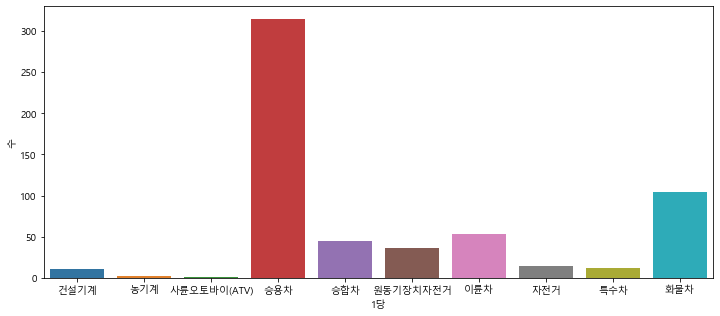

In [43]:
fig, ax = plt.subplots(nrows = 1)
fig.set_size_inches(12, 5)
sns.barplot(data = what1, x = '1당', y = '수')

In [44]:
tmp =df1[['1당', '사망자수', '피해인원']]

In [45]:
tmp = pd.pivot_table(data = tmp, index = ['1당'], aggfunc = 'sum')

In [46]:
tmp.reset_index(inplace = True)
tmp = tmp.sort_values(by = '1당')
tmp.reset_index(drop = True, inplace = True)

In [47]:
what1 = what1.sort_values(by = '1당')
what1.reset_index(drop = True, inplace = True)

In [48]:
tmp['수'] = what1['수']

In [49]:
tmp.rename(columns = {'수' : '사고횟수'}, inplace = True)

In [50]:
tmp

,1당,사망자수,피해인원,사고횟수
0,건설기계,11,13,11
1,농기계,3,3,3
2,사륜오토바이(ATV),1,1,1
3,승용차,326,449,314
4,승합차,45,55,45
5,원동기장치자전거,36,41,36
6,이륜차,55,67,54
7,자전거,15,16,15
8,특수차,12,23,12
9,화물차,111,153,105


In [51]:
tmp['사고대비피해율'] = tmp['피해인원'] / tmp['사고횟수'] * 100

In [52]:
tmp

,1당,사망자수,피해인원,사고횟수,사고대비피해율
0,건설기계,11,13,11,118.181818
1,농기계,3,3,3,100.000000
2,사륜오토바이(ATV),1,1,1,100.000000
3,승용차,326,449,314,142.993631
4,승합차,45,55,45,122.222222
5,원동기장치자전거,36,41,36,113.888889
6,이륜차,55,67,54,124.074074
7,자전거,15,16,15,106.666667
8,특수차,12,23,12,191.666667
9,화물차,111,153,105,145.714286


#### 5. 격자 노출

In [53]:
def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [54]:
from tqdm import tqdm_notebook

In [56]:
m = folium.Map(zoom_start = 10, location=[(35.411695+35.053023)/2,(128.361232+128.871067)/2])

# Generate GeoJson grid
top_right = [35.3399606,128.7691]
top_left = [35.1247574,128.463199]

grid = get_geojson_grid(top_right, top_left, n=30)

# Calculate exposures in grid
popups = []
regional_counts = []
heated_lat = []
heated_lng = []

for box in tqdm_notebook(grid):
    upper_right = box["properties"]["upper_right"]
    lower_left = box["properties"]["lower_left"]
    
    mask = (
        (df1.위도 <=upper_right[1]) & (df1.위도 >= lower_left[1]) &
        (df1.경도 <=upper_right[0]) & (df1.경도 >= lower_left[0])
           )
    
    region_incidents = len(df1[mask])

    regional_counts.append(region_incidents)

    total_vehicles = df1[mask].사망자수.sum()
    total_casualties = df1[mask].피해인원.sum()
    content = "total dead {:,.0f}, total casualties {:,.0f}".format(total_vehicles, total_casualties)
    popup = folium.Popup(content)
    popups.append(popup)

worst_region = max(regional_counts)

# Add GeoJson to map
for i, box in tqdm_notebook(enumerate(grid)):
    geo_json = json.dumps(box)

    color = plt.cm.Reds(regional_counts[i] / worst_region)
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 2,
                                                                        'dashArray': '5, 5',
                                                                        'fillOpacity': 0.55,
                                                                    })
    

    gj.add_child(popups[i])
    m.add_child(gj)

m.save('a.html')

TypeError: __init__() missing 1 required positional argument: 'location'

In [58]:
grid = get_geojson_grid(top_right, top_left, n=30)
grid

[{'type': 'FeatureCollection',
  'properties': {'lower_left': [128.463199, 35.1247574],
   'upper_right': [128.4733957, 35.13193084]},
  'features': [{'type': 'Feature',
    'geometry': {'type': 'Polygon',
     'coordinates': [[[128.463199, 35.13193084],
       [128.4733957, 35.13193084],
       [128.4733957, 35.1247574],
       [128.463199, 35.1247574],
       [128.463199, 35.13193084]]]}}]},
 {'type': 'FeatureCollection',
  'properties': {'lower_left': [128.4733957, 35.1247574],
   'upper_right': [128.4835924, 35.13193084]},
  'features': [{'type': 'Feature',
    'geometry': {'type': 'Polygon',
     'coordinates': [[[128.4733957, 35.13193084],
       [128.4835924, 35.13193084],
       [128.4835924, 35.1247574],
       [128.4733957, 35.1247574],
       [128.4733957, 35.13193084]]]}}]},
 {'type': 'FeatureCollection',
  'properties': {'lower_left': [128.4835924, 35.1247574],
   'upper_right': [128.4937891, 35.13193084]},
  'features': [{'type': 'Feature',
    'geometry': {'type': 'Polyg

In [72]:
final['피해인원'].mean()

1.265625

In [66]:
final = pd.DataFrame()

for i, box in enumerate(grid) :
    upper_right = box["properties"]["upper_right"]
    lower_left = box["properties"]["lower_left"]
    
    mask = (
        (df1.위도 <=upper_right[1]) & (df1.위도 >= lower_left[1]) &
        (df1.경도 <=upper_right[0]) & (df1.경도 >= lower_left[0])
           )

    if len(df1[mask]) > 7 :
        tmp = df1[mask]
        tmp = pd.DataFrame(tmp)
        tmp['Number'] = i
        
        final = pd.concat([final, tmp])

In [67]:
final.reset_index(drop = True, inplace = True)

In [68]:
final

,년월일,계절,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,피해인원,경도,위도,Number
0,20120615,Summer,June,금,00,야간,차대사람,횡단중,횡단중,교차로,교차로부근,신호위반,승용차,보행자,1,2,128.573328,35.199123,310
1,20121203,Winter,December,월,21,야간,차대차,추돌,주정차중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,128.572784,35.202870,310
2,20140505,Spring,May,월,01,야간,차대사람,차도통행중,차도통행중,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.567461,35.200699,310
3,20141014,Fall,October,화,18,야간,차대사람,횡단중,횡단중,단일로,기타단일로,안전운전 의무 불이행,화물차,보행자,1,1,128.570266,35.197983,310
4,20141022,Fall,October,수,06,주간,차대사람,횡단중,횡단중,교차로,교차로부근,안전운전 의무 불이행,승용차,보행자,1,1,128.567165,35.197447,310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20161101,Fall,November,화,18,야간,차대사람,횡단중,횡단중,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.620869,35.261384,585
60,20171005,Fall,October,목,07,주간,차대사람,기타,기타,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.620621,35.261747,585
61,20180830,Summer,August,목,19,야간,차대사람,횡단중,횡단중,교차로,교차로내,안전운전 의무 불이행,승용차,보행자,1,1,128.626340,35.261171,585
62,20181120,Fall,November,화,17,주간,차대사람,기타,기타,기타,기타,안전운전 의무 불이행,승용차,보행자,1,1,128.622691,35.262756,585


In [69]:
m = folium.Map(zoom_start = 10, location=[(35.411695+35.053023)/2,(128.361232+128.871067)/2])

# Generate GeoJson grid
top_right = [35.3399606,128.7691]
top_left = [35.1247574,128.463199]

grid = get_geojson_grid(top_right, top_left, n=30)

# Calculate exposures in grid
popups = []
regional_counts = []


for box in tqdm_notebook(grid):
    upper_right = box["properties"]["upper_right"]
    lower_left = box["properties"]["lower_left"]
    
    mask = (
        (final.위도 <=upper_right[1]) & (final.위도 >= lower_left[1]) &
        (final.경도 <=upper_right[0]) & (final.경도 >= lower_left[0])
           )

    region_incidents = len(final[mask])

    regional_counts.append(region_incidents)

    total_vehicles = len(final[mask])
    total_casualties = final[mask].피해인원.sum()
    content = "total dead {:,.0f}, total casualties {:,.0f}".format(total_vehicles, total_casualties)
    popup = folium.Popup(content)
    popups.append(popup)

worst_region = max(regional_counts)

# Add GeoJson to map
for i, box in tqdm_notebook(enumerate(grid)):
    geo_json = json.dumps(box)

    color = plt.cm.Reds(regional_counts[i] / worst_region)
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 2,
                                                                        'dashArray': '5, 5',
                                                                        'fillOpacity': 0.55,
                                                                    })

    gj.add_child(popups[i])
    m.add_child(gj)

    
for i in range(len(final)) :
    folium.Marker([final['위도'][i], final['경도'][i]],
                 popup = final['Number'][i]).add_to(m)
    
m.save('b.html') 

In [70]:
final

,년월일,계절,월,요일,시간,주야,사고_대,사고_중,사고유형,도로,도로형태,법규위반,1당,2당,사망자수,피해인원,경도,위도,Number
0,20120615,Summer,June,금,00,야간,차대사람,횡단중,횡단중,교차로,교차로부근,신호위반,승용차,보행자,1,2,128.573328,35.199123,310
1,20121203,Winter,December,월,21,야간,차대차,추돌,주정차중 추돌,단일로,기타단일로,안전운전 의무 불이행,승용차,승용차,1,3,128.572784,35.202870,310
2,20140505,Spring,May,월,01,야간,차대사람,차도통행중,차도통행중,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.567461,35.200699,310
3,20141014,Fall,October,화,18,야간,차대사람,횡단중,횡단중,단일로,기타단일로,안전운전 의무 불이행,화물차,보행자,1,1,128.570266,35.197983,310
4,20141022,Fall,October,수,06,주간,차대사람,횡단중,횡단중,교차로,교차로부근,안전운전 의무 불이행,승용차,보행자,1,1,128.567165,35.197447,310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20161101,Fall,November,화,18,야간,차대사람,횡단중,횡단중,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.620869,35.261384,585
60,20171005,Fall,October,목,07,주간,차대사람,기타,기타,단일로,기타단일로,안전운전 의무 불이행,승용차,보행자,1,1,128.620621,35.261747,585
61,20180830,Summer,August,목,19,야간,차대사람,횡단중,횡단중,교차로,교차로내,안전운전 의무 불이행,승용차,보행자,1,1,128.626340,35.261171,585
62,20181120,Fall,November,화,17,주간,차대사람,기타,기타,기타,기타,안전운전 의무 불이행,승용차,보행자,1,1,128.622691,35.262756,585


In [71]:
final['Number'].unique()

array([310, 400, 430, 461, 492, 498, 585], dtype=int64)